In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pmd

warnings.filterwarnings('ignore')
# Load in the time series and format it

sales = pd.read_csv('C:\\Users\\owner\\Downloads\\BMG_Dataset\\sales.csv')
sales = sales.dropna()
sales.index = pd.to_datetime(sales['Month'])
sales = sales.drop('Month', axis = 1)
sales.columns = ['Sales']

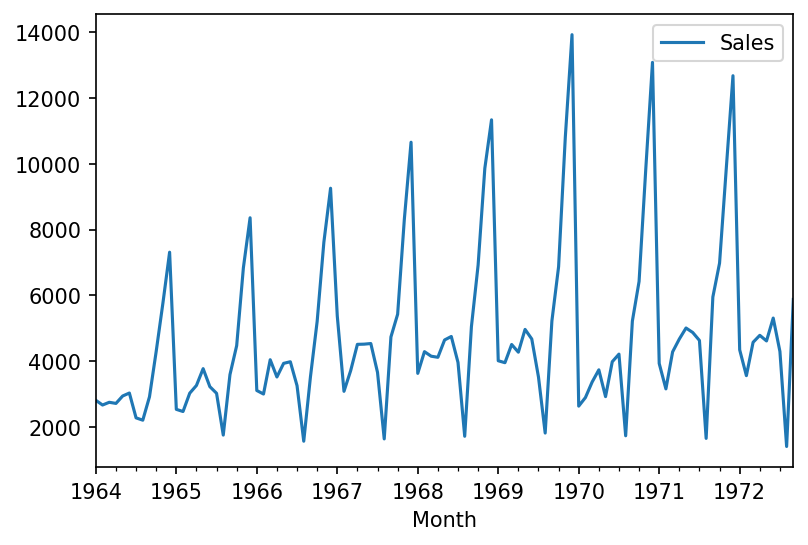

In [6]:
# Plot and show the time series on axis ax
fig, ax1 = plt.subplots()
sales.plot(ax = ax1)
plt.rcParams['figure.dpi'] = 150;
plt.show()

In [7]:
sales_diff = sales.diff()
sales_diff = sales_diff.dropna()

# Run test
result_diff = adfuller(sales_diff['Sales'])

# Print test statistic
print('This is the test-statistics:', round(result_diff[0],2))

# Print p-value
print('This is the p-value:', round(result_diff[1],2))

# Print critical values
print('List of t-stats required for different levels of significance: \n',result_diff[4])

This is the test-statistics: -7.19
This is the p-value: 0.0
List of t-stats required for different levels of significance: 
 {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}


# Below is a basic Auto-Regressive Model - 1

In [9]:
base_model = AutoReg(sales_diff, lags=1)

base_model_fit = base_model.fit()

base_preds = base_model_fit.predict(99,103) # last 5 months are predicted for comparison purpose

In [10]:
pred_df = pd.DataFrame(base_preds.values.reshape(-1,1) + sales.tail().values, index = base_preds.index, columns = ['Sales']).round(2)
pred_df

,Sales
1972-05-01,4628.45
1972-06-01,5357.51
1972-07-01,4264.01
1972-08-01,1536.16
1972-09-01,6172.31


# To get better predictions below is an ARIMA Model - 2

In [11]:
# Instantiate the model
sales_model = ARIMA(sales_diff, order=(3,0,1))

# Fit the model
sales_results = sales_model.fit()

# Print model fit summary
print(sales_results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  104
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -946.380
Date:                Fri, 23 Feb 2024   AIC                           1904.760
Time:                        13:51:46   BIC                           1920.626
Sample:                    02-01-1964   HQIC                          1911.188
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.9121     12.835      2.331      0.020       4.756      55.068
ar.L1          0.5133      0.142      3.611      0.000       0.235       0.792
ar.L2         -0.1961      0.262     -0.748      0.4

In [12]:
# Generate predictions for last 30 days to be compared with the actual
one_step_forecast = sales_results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

In [13]:
mean_forecast = pd.DataFrame(sales[-30:].values + mean_forecast.values.reshape(-1,1), index = mean_forecast.index, columns = ['Sales']).round()

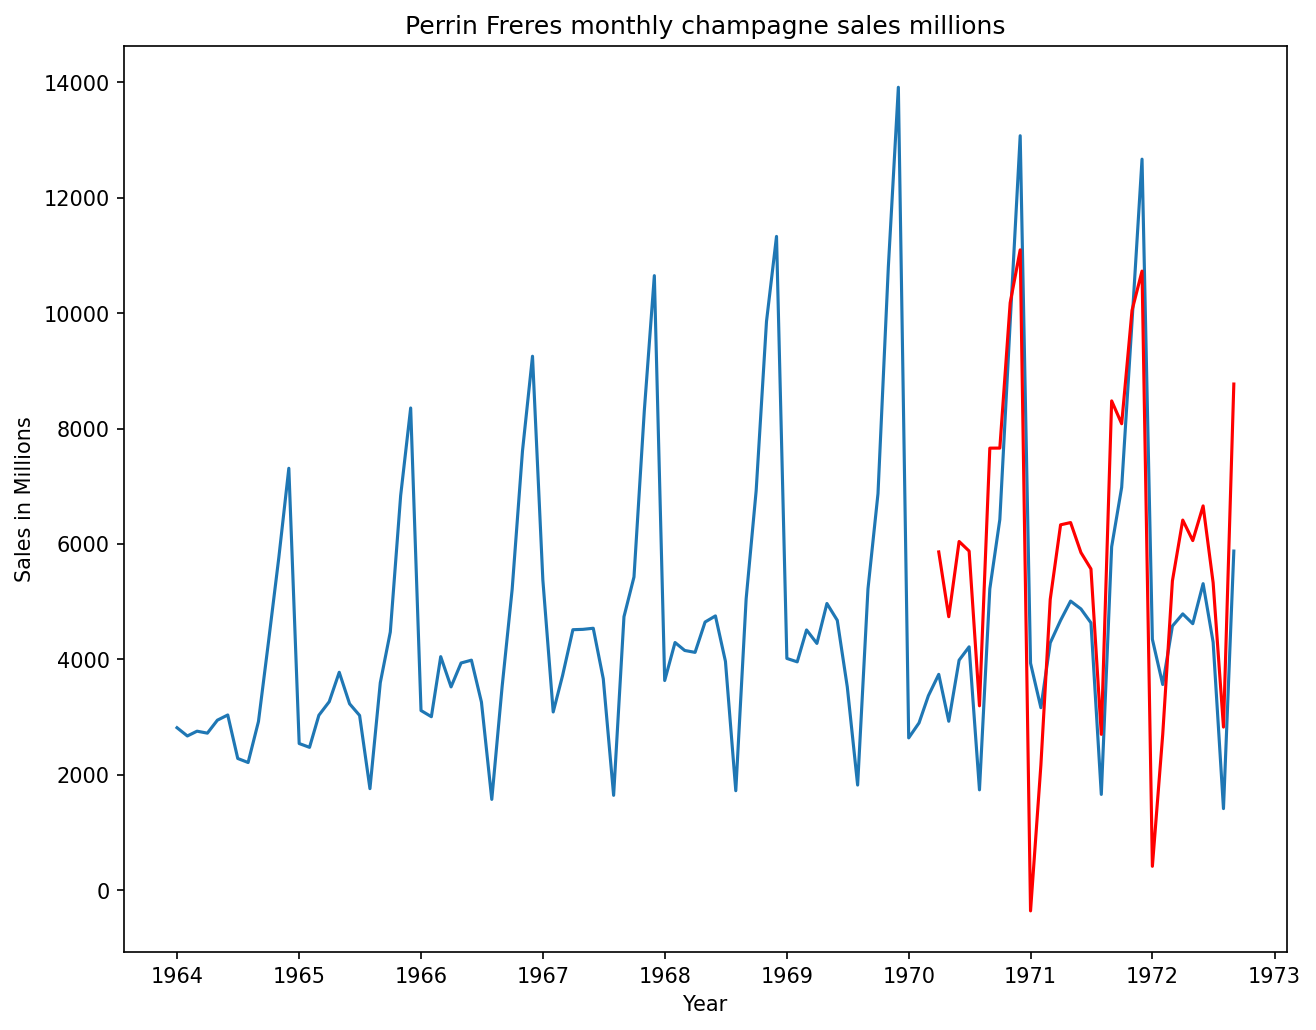

In [14]:
# plot the sales data
plt.figure(figsize=(10,8))
plt.plot(sales.index, sales['Sales'], label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast.values, color='r', label='forecast')
plt.title('Perrin Freres monthly champagne sales millions')
plt.xlabel("Year")
plt.ylabel("Sales in Millions");

In [15]:
mean_forecast[-5:] # last 5 months are predicted for comparison purposes

,Sales
1972-05-01,6059.0
1972-06-01,6660.0
1972-07-01,5329.0
1972-08-01,2826.0
1972-09-01,8772.0


# The third and final model to predict sales

In [16]:
train_sales = sales_diff[:70]

test_sales = sales_diff[70:]

sales_model=auto_arima(train_sales['Sales'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.302, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=938.769, Time=0.40 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=952.336, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=940.907, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=940.446, Time=0.79 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=940.670, Time=0.62 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=939.593, Time=0.39 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=948.649, Time=0.29 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=932.911, Time=0.24 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=931.550, Time=0.25 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=933.107, Time=0.15 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=93

In [17]:
sales_sarima = SARIMAX(test_sales['Sales'],order=(3,0,1),seasonal_order=(0,1,0,12)) # instantiating best model as above

sales_sarima_results = sales_sarima.fit() # fitting the best model

sales_last_35 = sales_sarima_results.get_prediction(steps=-35).predicted_mean # getting predictions
sales_last_35 = pd.DataFrame(sales[-34:].values + sales_last_35.values.reshape(-1,1), index = sales_last_35.index, columns = ['Sales']).round()

sales_next_7 = sales_sarima_results.get_forecast(steps=7).predicted_mean # getting predictions
sales_next_7 = sales_next_7 + np.mean(sales.values)

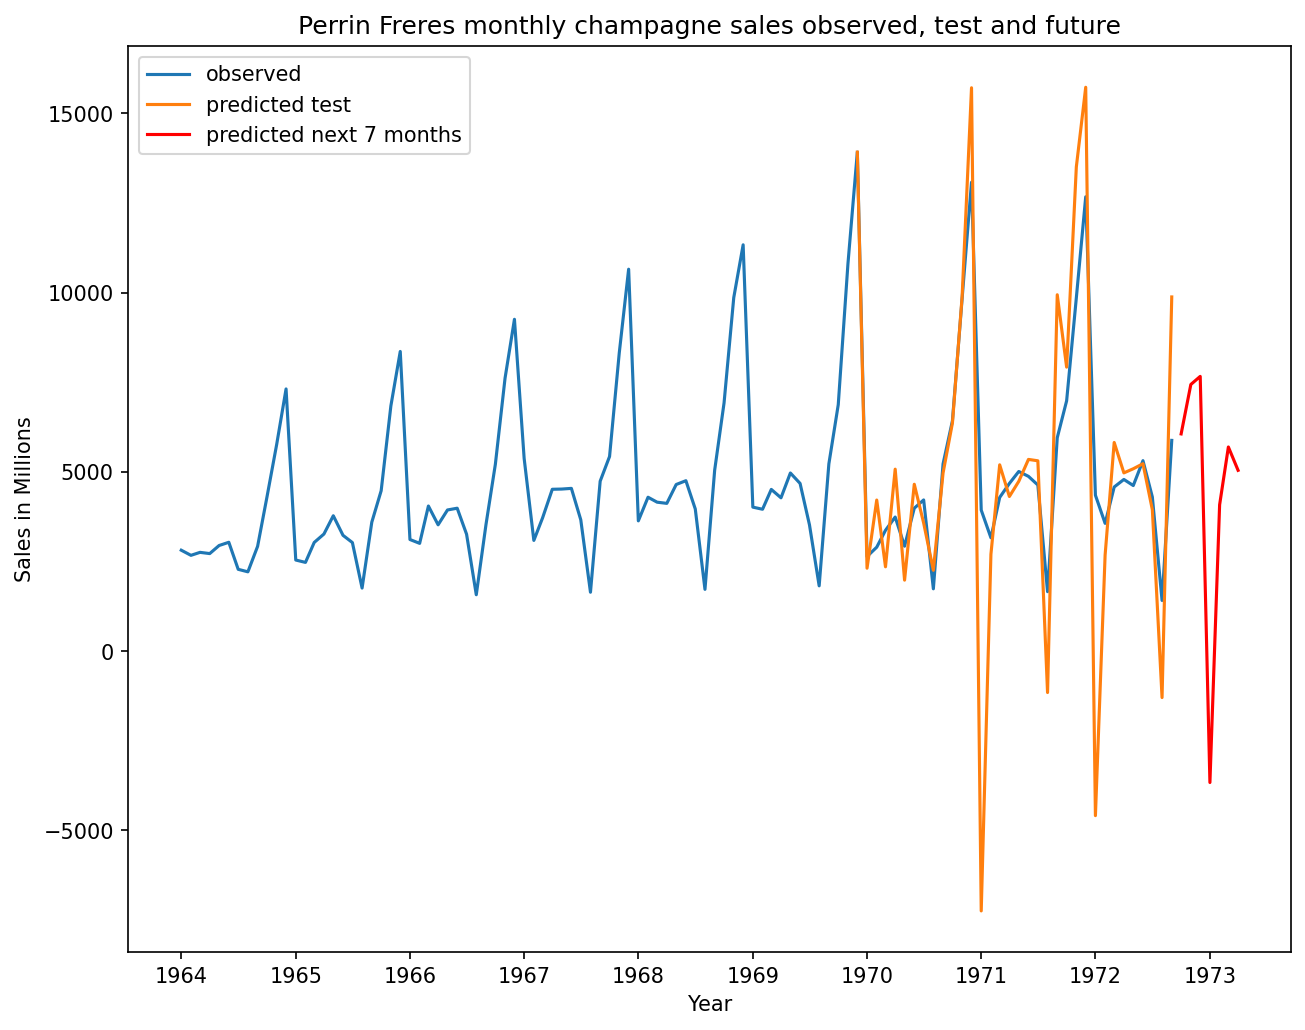

In [18]:
# Plot and show the actual vs predicted values for last 37 days to get a better view
plt.figure(figsize=(10,8))
plt.plot(sales.index, sales['Sales'], label='observed')

plt.plot(sales_last_35.index, sales_last_35.values, label='predicted test')
plt.plot(sales_next_7.index, sales_next_7, color = 'r', label='predicted next 7 months')
plt.title('Perrin Freres monthly champagne sales observed, test and future')
plt.xlabel('Year')
plt.ylabel('Sales in Millions')
plt.legend();

# Hotel data analysis

In [19]:
hotel_df = pd.read_csv('C:\\Users\\owner\\Downloads\\BMG_Dataset\\hotel.csv')
hotel_df['date'] = pd.to_datetime(hotel_df['arrival_date_month'].astype(str)+ '-' + hotel_df['arrival_date_day_of_month'].astype(str) + '-' + hotel_df['arrival_date_year'].astype(str))
hotel_df = hotel_df.drop(['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], axis = 1)

In [20]:
time_series_df = hotel_df[hotel_df['is_canceled'] == 0].groupby(['date'])['name'].count()
time_series_df = pd.DataFrame({'date':time_series_df.index, 'Demand':time_series_df.values})
time_series_df.set_index('date', inplace=True)

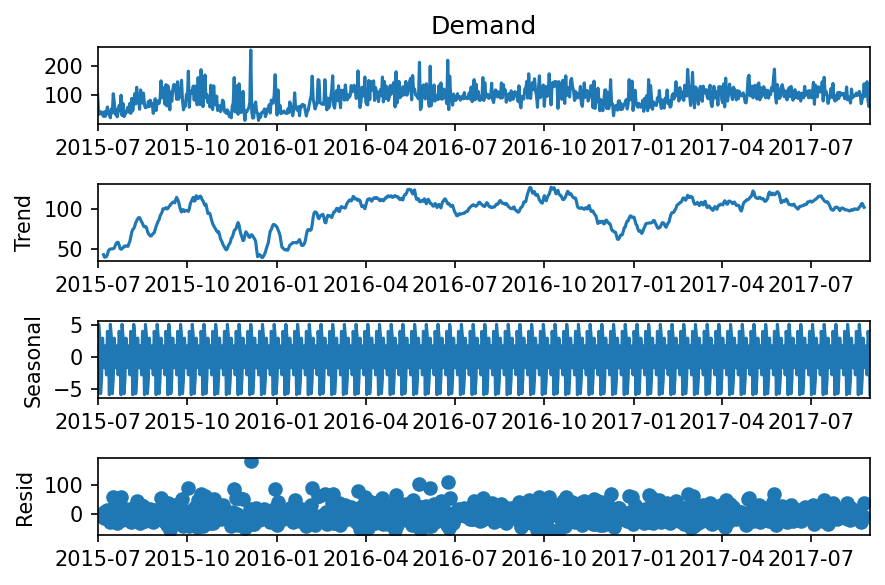

In [21]:
decomposition=seasonal_decompose(time_series_df['Demand'],model='additive',period=12)
decomposition.plot()
plt.show()

In [22]:
hotel_adf = adfuller(time_series_df)

# Print test statistic
print('This is the test-statistics:', round(hotel_adf[0],2))

# Print p-value
print('This is the p-value:', round(hotel_adf[1],2))

# Print critical values
print('List of t-stats required for different levels of significance: \n',hotel_adf[4])

This is the test-statistics: -3.67
This is the p-value: 0.0
List of t-stats required for different levels of significance: 
 {'1%': -3.4387723094153286, '5%': -2.8652573313919625, '10%': -2.5687494684274794}


In [23]:
# segregating data to train the model
train_hotel = time_series_df[:700] 

# segregating data to test the model
test_hotel = time_series_df[700:]

In [24]:
hotel_model=pmd.auto_arima(train_hotel['Demand'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6999.749, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=6937.752, Time=1.65 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6952.007, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8436.989, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=6947.481, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=6913.965, Time=6.58 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=7588.733, Time=6.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=6932.316, Time=3.31 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=6928.680, Time=5.12 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=6892.636, Time=8.36 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=6906.164, Time=1.52 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=7823.750, Time=7.03 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=6907.762, Time=3.20 sec
 ARIMA(3,0,0)(2,0,0)[12]

In [25]:
final_model = SARIMAX(time_series_df['Demand'],order=(5,0,0),seasonal_order=(2,0,0,12)) # instantiating best model as above

final_model_results = final_model.fit() # fitting the best model

forecast_last_30 = final_model_results.get_prediction(steps=-30).predicted_mean # getting predictions

forecast_next_7 = final_model_results.get_forecast(steps=7).predicted_mean # getting predictions

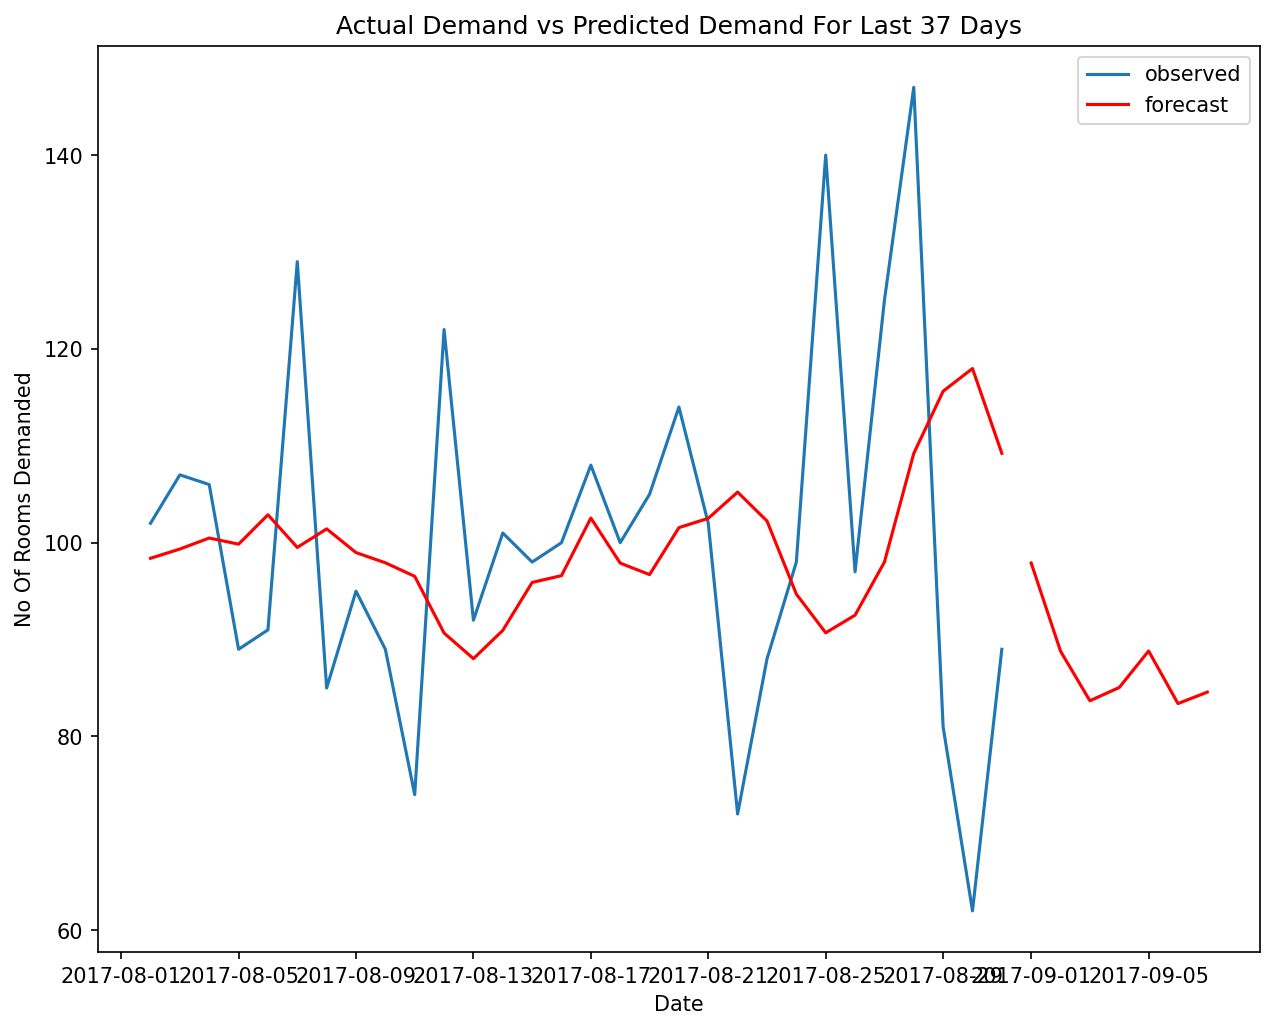

In [26]:
# Plot and show the actual vs predicted values for last 37 days to get a better view
plt.figure(figsize=(10,8))
plt.plot(time_series_df[-30:].index, time_series_df[-30:]['Demand'], label='observed')

# plot your mean predictions
plt.plot(forecast_last_30[763:].index, forecast_last_30[763:], color='r', label='forecast')

plt.plot(forecast_next_7.index, forecast_next_7, color='r')

plt.legend()
plt.title("Actual Demand vs Predicted Demand For Last 37 Days")
plt.xlabel("Date")
plt.ylabel("No Of Rooms Demanded");

In [27]:
cand_df = hotel_df[hotel_df['is_canceled'] != 0][['hotel', 'is_canceled','lead_time', 'assigned_room_type', 'market_segment', 'deposit_type']]
cand_groupd_df = cand_df.groupby(['hotel', 'market_segment'])['lead_time'].mean()

In [28]:
dep_type_groupd_df = cand_df.groupby(['hotel','deposit_type'])['is_canceled'].count()

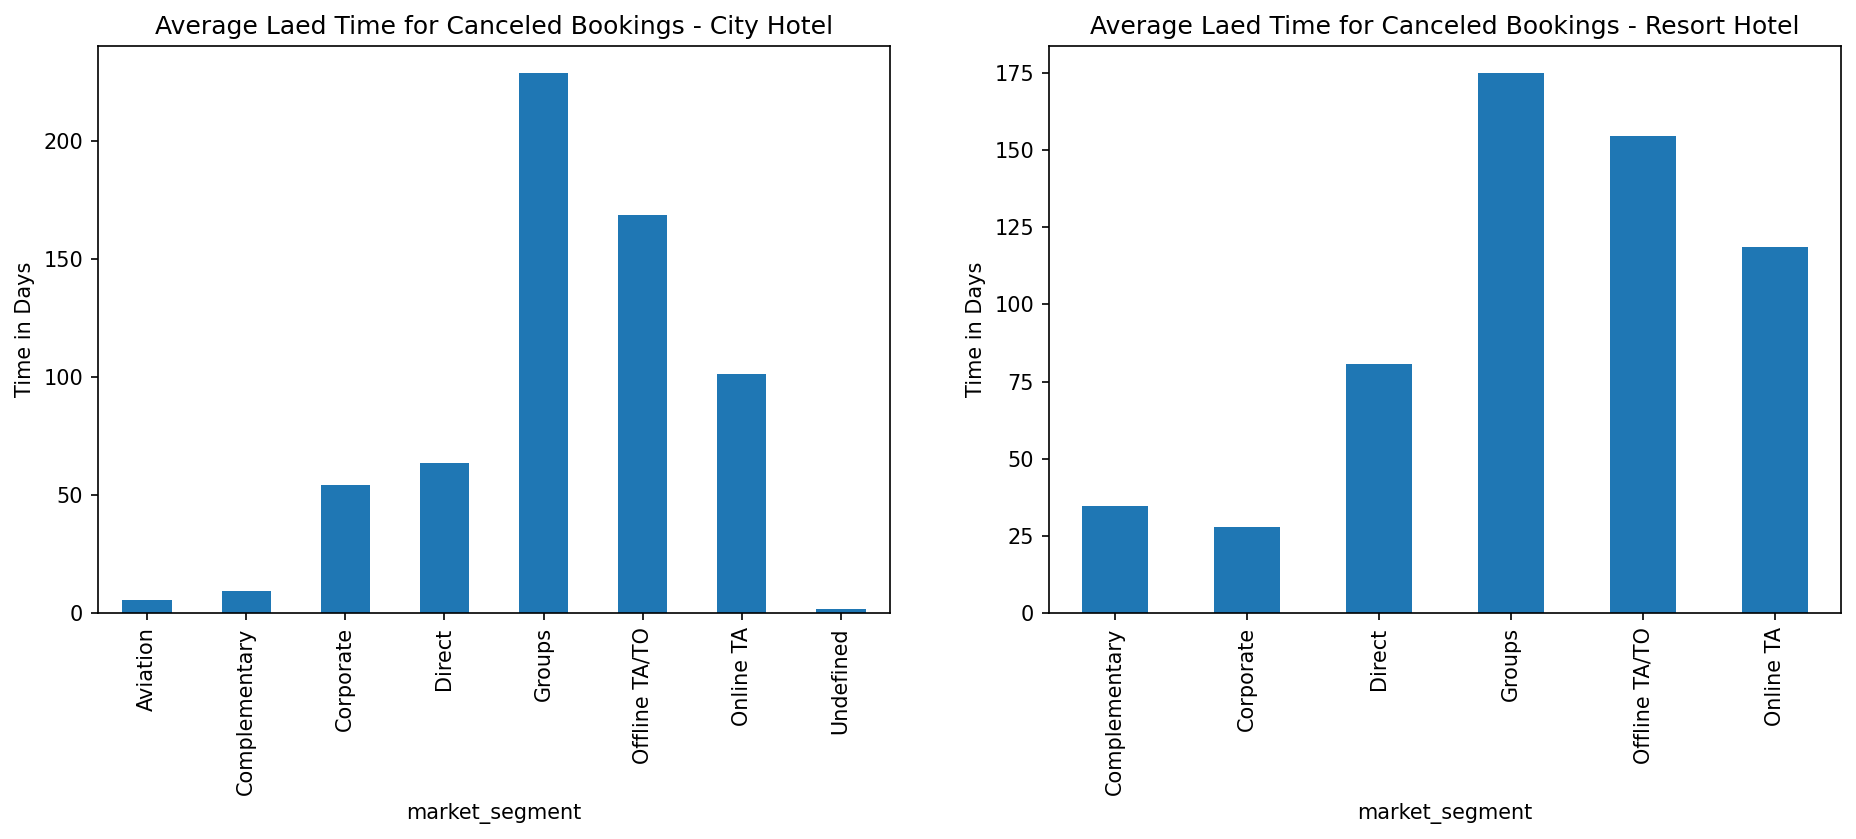

In [29]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.set_title('Average Laed Time for Canceled Bookings - City Hotel')
ax1.set_ylabel('Time in Days')
cand_groupd_df.loc['City Hotel'].plot.bar(ax=ax1)

ax2.set_title('Average Laed Time for Canceled Bookings - Resort Hotel')
ax2.set_ylabel('Time in Days')
cand_groupd_df.loc['Resort Hotel'].plot.bar(ax=ax2);

In [30]:
df = pd.DataFrame(dep_type_groupd_df)
df.columns = ['Canceled']

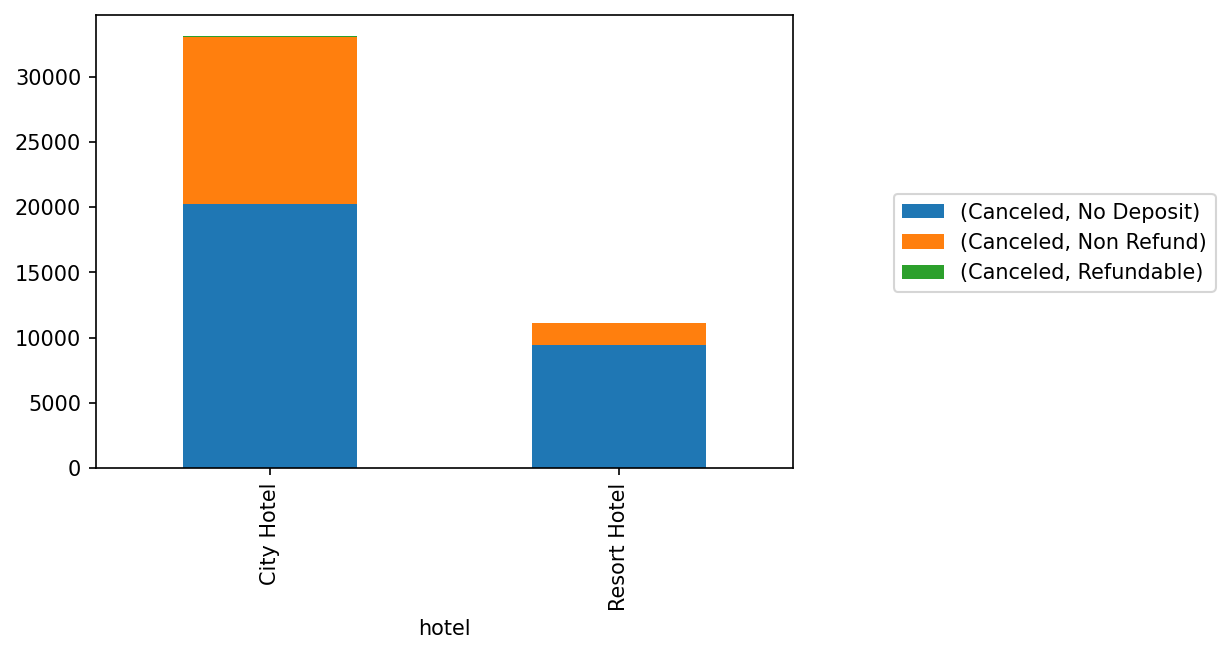

In [31]:
ax8 = df.unstack(level=1).plot(kind='bar', stacked=True, legend = False)
ax8.figure.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rcParams['figure.dpi'] = 150;